# <center>Training a Decentralized Machine Learning Model</center>

In this phase, we will train a decentralized machine learning (ML) model using Horizontal Federated Learning (HFL), where five clients collaboratively train a model on fraud transaction data without sharing their raw data. Each client retains its dataset locally, and only model updates are exchanged, ensuring privacy and compliance with data protection regulations.

Unlike centralized ML, where data is aggregated in a single location, HFL addresses privacy concerns, data silos, and regulatory constraints**. After benchmarking the centralized model, we will compare its performance, efficiency, and trade-offs against the federated approach to assess its viability in fraud detection.

--- 

In [33]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.32.0

torch: 2.6.0
flwr : 1.14.0



--------

## Loading Dependencies

In [42]:
import os
import sys
sys.path.append("../")

import ray 
import torch
import torch.nn as nn

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.config import NUM_CLASSES, NUM_FEATURES, SERVER_CONFIG
from src.train_decentralized import train_model
from src.FL_client import BankFLClient
from src.FL_server import weighted_average, evaluate 
from src.local_utility import load_client_data, load_test_data, get_weights, set_weights
from src.local_utility import set_device, set_seed

------

In [43]:
DEVICE = set_device()
set_seed()

In [44]:
# Load Datasets
num_clients = SERVER_CONFIG['num_clients']
train_sets = []
val_sets = []

for i in range(num_clients):
    train_set, val_set = load_client_data(i)
    train_sets.append(train_set)
    val_sets.append(val_set)

test_set = load_test_data()

------

In [45]:
#2. Define Model 

class FraudDetectionModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(

            # 1st hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # output layer
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

----

In [46]:
def client_fn(context: Context) -> Client:
    """
    Create a federated learning client
    """
    partition_id = int(context.node_config["partition-id"]) # Get the client partition ID
    model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [47]:
model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
params = ndarrays_to_parameters(get_weights(model))

def server_fn(context: Context):
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<-- Sample 100% of available clients for training
        fraction_evaluate=1.0,
        initial_parameters=params,
        evaluate_fn=evaluate, 
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    sever_config = ServerConfig(num_rounds=50) #<--- no. of federated rounds
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Instantiate the sever app
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client
> - `env_vars`: ensure Ray workers inherit the correct environment

In [48]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-02-07 16:26:20,488	INFO worker.py:1752 -- Started a local Ray instance.
2025-02-07 16:26:22,484	INFO packaging.py:530 -- Creating a file package for local directory 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-02-07 16:26:22,776	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_836a0e34c4059eaf.zip' (12.93MiB) to Ray cluster...
2025-02-07 16:26:22,836	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_836a0e34c4059eaf.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.7115471545530825, {'accuracy': 0.35800064913988966}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: rece


Accuracy: 0.80 | Recall: 0.73 | Precision: 0.72 | ROC-AUC: 0.86

 ___________________________________________________________________________________________________ 



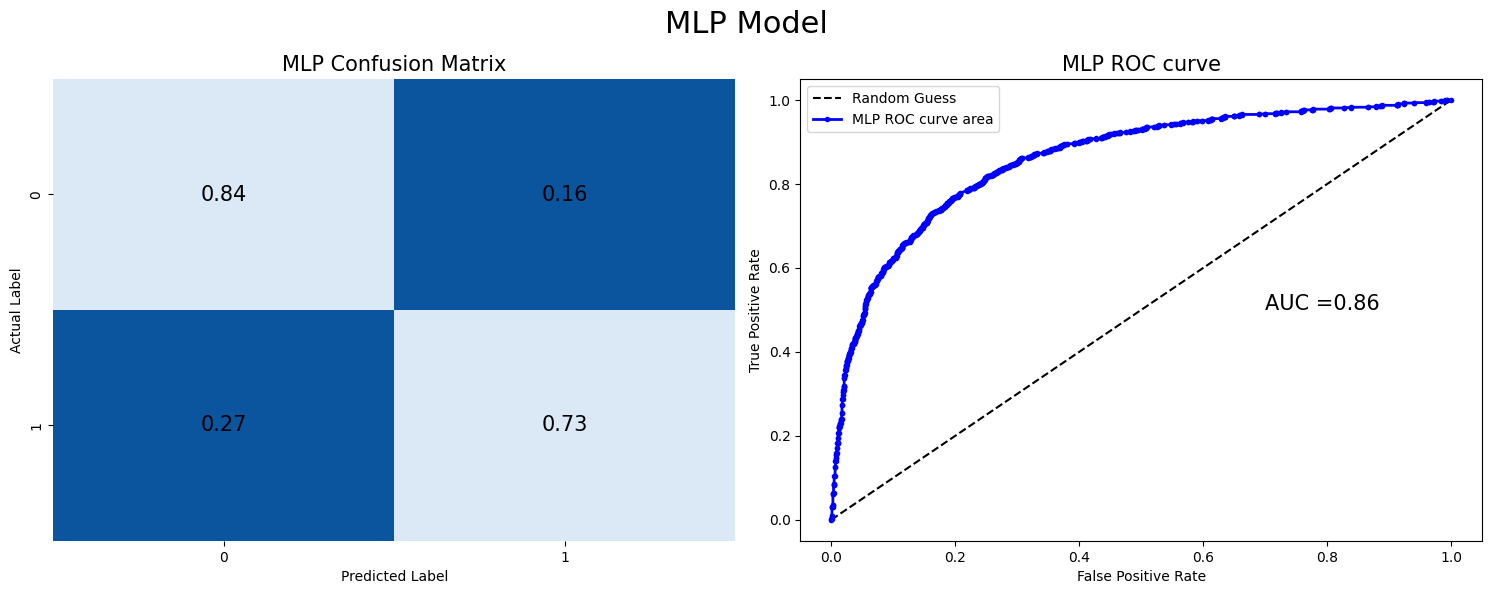

INFO :      fit progress: (10, 0.49912881912017354, {'accuracy': 0.7994157740993184}, 86.5161872000026)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1978
           1       0.72      0.73      0.72      1103

    accuracy                           0.80      3081
   macro avg       0.78      0.78      0.78      3081
weighted avg       0.80      0.80      0.80      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (11, 0.5118504990728534, {'accuracy': 0.7984420642648491}, 89.31282629999623)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 0.5241126822573798, {'accuracy': 0.7964946445959105}, 91.96726990000025)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: re

In [49]:
project_root =  os.path.abspath("..") 
ray.init(runtime_env={"working_dir": project_root})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)